In [2]:
import torch
from torch import nn

from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *
from einops import rearrange, reduce, repeat


torch.backends.cudnn.benchmark = True

img_wh = (157, 134)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/silica4/', 'test_train', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['llff2d'] \
          ('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'val',
           img_wh=img_wh)

train_dataset = dataset_dict['llff2d'] \
          ('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'train',
           img_wh=img_wh)

/home2/sdokania/.local/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


val image is /ssd_scratch/cvit/shubham/nerf_llff_data/fern/images/IMG_4038.JPG


In [3]:
len(train_dataset)

304

In [4]:
sample = train_dataset[0]
rays = sample['rays']

In [5]:
rays.shape

torch.Size([34, 40, 8])

In [6]:
embedding_xyz = Embedding(3, 10).cuda()
embedding_dir = Embedding(3, 4).cuda()

embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}

nerf_coarse = NeRF2D().cuda()#K=[1,1,1,1,1,1])
nerf_fine = NeRF2D().cuda()#K=[1,1,1,1,1,1])
models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [7]:
def sample_pdf2d(bins, weights, N_importance, det=False, eps=1e-5):
    h_, w_, ns = weights.shape
    weights = weights + eps # avoid division by zero error
    pdf = weights / reduce(weights, 'h w n -> h w 1', 'sum')
    cdf = torch.cumsum(pdf, -1)

    if det:
        # Stupid error here if we don't substract with eps. 1 can be included in the
        # matrix and it can give error later.
        u = torch.linspace(eps, 1, N_importance, device=bins.device) - eps
        u = u.expand(h_, w_, N_importance)
        u = u.contiguous()
    else:
        u = eps + torch.rand(h_, w_, N_importance, device=bins.device)*(1-eps)
    # um = u.max().item() == u.min().item()
    # print(u.max(), u.min())
    # u = u.contiguous()
    

    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.clamp_min(inds-1, 0)
    above = torch.clamp_max(inds, ns)

    inds_sampled = rearrange(torch.stack([below, above], -1), 'h w n2 c -> h w (n2 c)', c=2)
    cdf_g = rearrange(torch.gather(cdf, 2, inds_sampled), 'h w (n2 c) -> h w n2 c', c=2)
    bins_g = rearrange(torch.gather(bins, 2, inds_sampled), 'h w (n2 c) -> h w n2 c', c=2)

    denom = cdf_g[..., 1] -cdf_g[..., 0]
    try:    
        if (denom<eps).sum() > 0:
            denom[denom<eps] = 1 # denom equals 0 means a bin has weight 0,
                                # in which case it will not be sampled
                                # anyway, therefore any value for it is fine (set to 1 here)
    except:
        print(u.min(), u.max())

    samples = bins_g[...,0] + (u-cdf_g[...,0])/denom * (bins_g[...,1]-bins_g[...,0])
    return samples


In [8]:
def render_2d_rays(models,
                embeddings,
                rays,
                N_samples=64,
                use_disp=False,
                perturb=0,
                noise_std=1,
                N_importance=0,
                chunk=1024*32,
                white_back=False,
                test_time=False,
                **kwargs
                ):
    
    def inference(results, model, typ, xyz, z_vals, test_time=False, **kwargs):
        B = xyz.shape[0]
        out_chunks = []
        if typ == 'coarse' and test_time and 'fine' in models:
            for i in range(B):
                part = xyz[i:i+1]
                _b, _c, _h, _w = part.shape

                part_emb = embedding_xyz(rearrange(part, 'b c h w -> (b h w) c'))
                part_emb = rearrange(part_emb, '(b h w) c -> b c h w', b=_b, h=_h, w=_w)
                out_chunks += [model(part_emb, sigma_only=True)]
            
            out = torch.cat(out_chunks, 0)
            sigmas = rearrange(out, 'b 1 h w -> h w b')
        else:
            dir_embedded = repeat(dir_emb, 'b c h w -> (b B) c h w', B=B)
            for i in range(B):
                part = xyz[i:i+1]
                _b, _c, _h, _w = part.shape

                part_emb = embedding_xyz(rearrange(part, 'b c h w -> (b h w) c'))
                part_emb = rearrange(part_emb, '(b h w) c -> b c h w', b=_b, h=_h, w=_w)
                input_emb = torch.cat([part_emb, dir_embedded[i:i+1]], 1)
                out_chunks += [model(input_emb, sigma_only=False)]
            
            out = torch.cat(out_chunks, 0)
            out = rearrange(out, 'b c h w -> h w b c')
            rgbs = out[..., :3]
            sigmas = out[..., 3]
        
        # Now time for processing the inferred data for rendering
        deltas = z_vals[..., 1:] - z_vals[..., :-1]
        delta_inf = 1e10 * torch.ones_like(deltas[..., :1])
        deltas = torch.cat([deltas, delta_inf], -1)
        
        # compute alpha
        noise = torch.randn_like(sigmas) * noise_std
        alphas = 1-torch.exp(-deltas * torch.relu(sigmas + noise))
        
        alphas_shifted = \
            torch.cat([torch.ones_like(alphas[..., :1]), 1-alphas+1e-10], -1)
        weights = \
            alphas * torch.cumprod(alphas_shifted[..., :-1], -1)
        weights_sum = reduce(weights, 'h w b -> h w', 'sum')
        
        results[f'weights_{typ}'] = weights
        results[f'opacity_{typ}'] = weights_sum
        results[f'z_vals_{typ}'] = z_vals
        if test_time and typ == 'coarse' and 'fine' in models:
            return
        
        # render colors now
        rgb_map = reduce(rearrange(weights, 'h w b -> h w b 1')*rgbs, 'h w b c -> h w c', 'sum')
        depth_map = reduce(weights * z_vals, 'h w b -> h w', 'sum')

        if white_back:
            rgb_map += 1-weights_sum.unsqueeze(-1)
        
        results[f'rgb_{typ}'] = rgb_map
        results[f'depth_{typ}'] = depth_map
        
        return


    embedding_xyz, embedding_dir = embeddings['xyz'], embeddings['dir']
    
    # Decompose the inputs
    h, w, _ = rays.shape
    rays_o, rays_d = rays[..., 0:3], rays[..., 3:6]
    near, far = rays[..., 6:7], rays[..., 7:8]

    # Apply direction embedding
    _h, _w, _c = rays_d.shape
    dir_emb = embedding_dir(rearrange(rays_d, 'h w c -> (h w) c'))
    dir_emb = rearrange(dir_emb, '(h w) c -> 1 c h w', h=_h, w=_w)

    rays_o = rearrange(rays_o, 'n1 n2 c -> n1 n2 1 c')
    rays_d = rearrange(rays_d, 'n1 n2 c -> n1 n2 1 c')

    # sample depth points
    z_steps = torch.linspace(0, 1, N_samples, device=rays.device)
    if not use_disp: # use linear sampling in depth space
        z_vals = near * (1-z_steps) + far * z_steps
    else: # use linear sampling in disparity space
        z_vals = 1/(1/near * (1-z_steps) + 1/far * z_steps)

    if perturb > 0: # perturb sampling depths (z_vals)
        z_vals_mid = 0.5 * (z_vals[..., :-1] + z_vals[... ,1:]) # (N_rays, N_samples-1) interval mid points
        # get intervals between samples
        upper = torch.cat([z_vals_mid, z_vals[... ,-1:]], -1)
        lower = torch.cat([z_vals[... ,:1], z_vals_mid], -1)
        
        perturb_rand = perturb * torch.rand_like(z_vals)
        z_vals = lower + (upper - lower) * perturb_rand

    xyz_coarse = rays_o + rays_d * rearrange(z_vals, 'n1 n2 c -> n1 n2 c 1')
    xyz_coarse = rearrange(xyz_coarse, 'h w b c -> b c h w')
    # print(xyz_coarse.shape, z_vals.shape, dir_emb.shape)
    
    results = {}
    inference(results, models['coarse'], 'coarse', xyz_coarse, z_vals, test_time)
    
    if N_importance > 0: # Sample points for the fine model
        z_vals_mid = 0.5 * (z_vals[..., :-1] + z_vals[..., 1:])
        # return z_vals_mid, results['weights_coarse'][..., 1:-1].detach(), N_importance
        z_vals_ = sample_pdf2d(z_vals_mid, results['weights_coarse'][..., 1:-1].detach(),
                            N_importance, det=(perturb==0))
        z_vals = torch.sort(torch.cat([z_vals, z_vals_], -1), -1)[0]
        
        # prepare fine points
        xyz_fine = rays_o + rays_d * rearrange(z_vals, 'n1 n2 c -> n1 n2 c 1')
        xyz_fine = rearrange(xyz_fine, 'h w b c -> b c h w')

        inference(results, models['fine'], 'fine', xyz_fine, z_vals, test_time, **kwargs)
    
    return results

In [9]:
sample = dataset[0]
rays, rgbs = sample['rays'].cuda(), sample['rgbs'].cuda()

rays.shape
# sample.keys()

torch.Size([134, 157, 8])

In [12]:
tot = 0

for trx in range(10):
    if dataset.apply_skip:
        # Create a template for the outputs
        template_rgb_coarse = torch.zeros_like(rgbs)
        template_rgb_fine = torch.zeros_like(rgbs)
        template_depth_coarse = torch.zeros_like(rgbs[..., 0])
        template_depth_fine = torch.zeros_like(rgbs[..., 0])
        # Divide the data samples
        for sx in range(dataset.skips[0]):
            for sy in range(dataset.skips[1]):
                rays_segment = rays[sx::dataset.skips[0], sy::dataset.skips[1]]
                with torch.no_grad():
                    op = render_2d_rays(models,
                                    embeddings,
                                    rays_segment,
                                    N_samples=32,
                                    use_disp=False,
                                    perturb=1.2,
                                    noise_std=1,
                                    N_importance=128,
                                    chunk=1024*32,
                                    white_back=False,
                                    test_time=False,
                                    )
                template_rgb_coarse[sx::dataset.skips[0], sy::dataset.skips[1]] = op['rgb_coarse']
    print(tot)

0
0
0
0
0
0
0
0
0
0


In [13]:
(template_rgb_coarse - rgbs).mean()

tensor(-0.1986, device='cuda:0')

In [20]:
# with torch.no_grad():
#     op = render_2d_rays(models,
#                     embeddings,
#                     rays,
#                     N_samples=32,
#                     use_disp=False,
#                     perturb=0,
#                     noise_std=1,
#                     N_importance=10,
#                     chunk=1024*32,
#                     white_back=False,
#                     test_time=False,
#                     )

In [10]:
for kx in op.keys():
    print(kx, op[kx].shape)

weights_coarse torch.Size([34, 34, 32])
opacity_coarse torch.Size([34, 34])
z_vals_coarse torch.Size([34, 34, 32])
rgb_coarse torch.Size([34, 34, 3])
depth_coarse torch.Size([34, 34])
weights_fine torch.Size([34, 34, 42])
opacity_fine torch.Size([34, 34])
z_vals_fine torch.Size([34, 34, 42])
rgb_fine torch.Size([34, 34, 3])
depth_fine torch.Size([34, 34])


In [ ]:
# We need the follows
# rgb_coarse
# rgb_fine
# depth_coarse
# depth_fine

In [9]:
# op = render_2d_rays(models,
#                 embeddings,
#                 rays,
#                 N_samples=64,
#                 use_disp=False,
#                 perturb=0,
#                 noise_std=1,
#                 N_importance=64,
#                 chunk=1024*32,
#                 white_back=False,
#                 test_time=False,
#                 )

128

## Build CNN model here

In [93]:
from torch import nn

In [94]:
part = xyz_coarse[2:3]
_b, _c, _h, _w = part.shape

part_emb = embedding_xyz(rearrange(part, 'b c h w -> (b h w) c'))
part_emb = rearrange(part_emb, '(b h w) c -> b c h w', b=_b, h=_h, w=_w)
print(part_emb.shape)

torch.Size([1, 63, 400, 400])


In [96]:
net = NeRF2D(K=[3, 5, 1, 1, 5, 3, 1, 1])

In [97]:
out = net(torch.cat([part_emb, dir_emb], 1), sigma_only=False)
out.shape

torch.Size([1, 4, 400, 400])

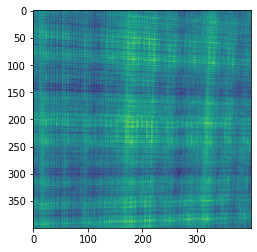

In [105]:
# plt.imshow(out[0, ].permute(1, 2, 0).data.numpy())
plt.imshow(out[0, 3].data.numpy())

<function einops.einops.rearrange(tensor, pattern, **axes_lengths)>